---
title: "Wisconsin Immigration Arrests"
date: "2025-07-18"
# categories: [news, stata]
format:
  html:
    code-fold: true
image: wisconsin.png
jupyter: nbstata
---

New data on immigration arrests was released recently. I learned about it from an [Axios article](https://www.axios.com/2025/07/17/trump-ice-raids-arrests-immigration) yesterday highlighting the June increase in non-criminal arrests (non-criminal because "being in the U.S. illegally is a civil, not criminal, violation"). The article led with the following chart:

::: {layout="[[-20,60,-20]]"}
![Axios chart](image.png){.lightbox fig-alt="Axios chart of ICE arrests by reported criminal status"}
:::

I was curious whether there had been a proportionate increase in ICE arrests near me in Wisconsin, as opposed to the increase being concentrated in places like California. So I downloaded the data from the [Deportation Data Project](https://deportationdata.org/data/ice.html).^[The "Late June 2025" Arrests data, specifically.]

In [1]:
*| code-summary: "Import data into Stata"
clear all
quietly import excel "C:\Users\tjhuegerich\Downloads\2025-ICLI-00019_2024-ICFO-39357_ERO Admin Arrests_raw.xlsx", sheet("Admin Arrests") cellrange(A7:W265233) firstrow

The raw data is detailed enough to identify individual arrests by date and location.^[For instance, I was able to find the record for an acquaintance arrested in the Madison area. He is classified in the data as a "Convicted Criminal" despite, I'm told, merely having the same name as a fugitive from a different country, one thousands of miles away from his own. So maybe take these ICE classifications with a grain of salt.] But here I just need date, state, and "criminal status."

In [2]:
*| code-summary: "Collapse to counts by state and criminal classification"
gen date = dofc(ApprehensionDate)
quietly drop if date > mdy(6,26,2025) // limited 6/27 data
encode ApprehensionCriminality, gen(cs_id)
assert !missing(BirthYear)
collapse (count) n=BirthYear, by(date ApprehensionState cs_id)

First I confirmed that I could replicate the Axios chart.

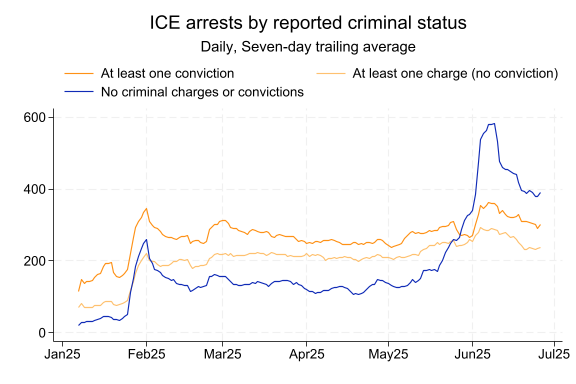

In [3]:
*| code-summary: Replicate Axios chart
*| fig-cap: "Note: Arrests were counted even if they did not lead to detainment; Multiple arrests of the same individual were counted separately; original chart by Kavya Beheraj/Axios."
frame copy default NATIONAL
frame NATIONAL {
    collapse (sum) n, by(date cs_id)
    quietly {
        xtset cs_id date
        tsfill, full
        replace n = 0 if missing(n)
        tssmooth ma n_7trailing_ = n, window(6 1 0)
        drop n
        reshape wide n_7trailing_ , i(date) j(cs_id)
    }
    format date %tdMonYY
    label var n_7trailing_1 "At least one conviction"
    label var n_7trailing_2 "At least one charge (no conviction)"
    label var n_7trailing_3 "No criminal charges or convictions"
    tsline n_7trailing_1 n_7trailing_2 n_7trailing_3 if date >= mdy(1,7,2025), ///
        lcolor("#FE9116" "#FEC170" "#102BB6") xtitle("") xlabel(#7) legend(position(12)) ///
        title("ICE arrests by reported criminal status") ///
        subtitle("Daily, Seven-day trailing average")
}

Then I zoomed out to allow a comparison between the Biden and Trump administrations, also using a different style of chart to more easily see total immigration arrests.

::: {.content-hidden when-format="html"}

https://www.statalist.org/forums/forum/general-stata-discussion/general/1434462-stacked-area-plot

:::

## National

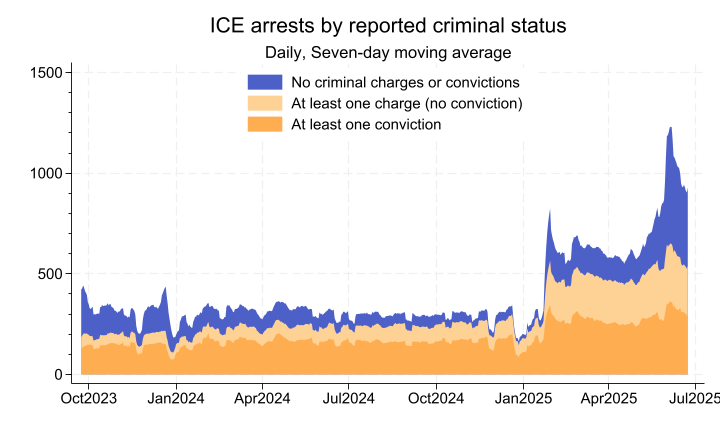

In [4]:
*| code-summary: Expand and reformat national chart
frame NATIONAL {
    quietly replace date = date - 3 // center moving averages
    gen cumul2_7t = n_7trailing_1 + n_7trailing_2
    gen cumul3_7t = cumul2_7t + n_7trailing_3
    *label var n_7trailing_1 "At least one conviction"
    label var cumul2_7t "At least one charge (no conviction)"
    label var cumul3_7t "No criminal charges or convictions"
    format date %tdMonCCYY
    twoway (area cumul3_7t cumul2_7t n_7trailing_1 date if date >= mdy(9,23,2023), ///
            color("#102BB6" "#FEC170" "#FE9116") fintensity(75 75 75) lwidth(none none none)), ///
        xtitle("") legend(ring(0) bplacement(12)) xlabel(#11) ymtick(##5) ///
        title("ICE arrests by reported criminal status") ///
        subtitle("Daily, Seven-day moving average")
}

## California

The same chart limited to California shows a Trump Administration increase in arrests just as large as the national one, with an even more pronounced increase in June.

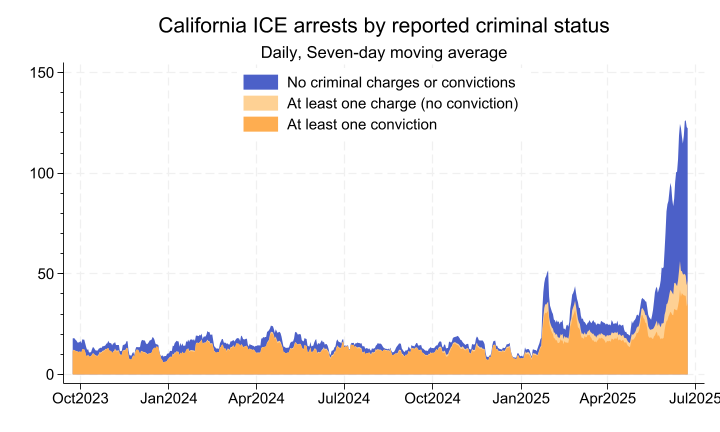

In [5]:
*| code-summary: Create California chart
frame copy default CALIFORNIA
frame CALIFORNIA {
    quietly keep if ApprehensionState == "CALIFORNIA"
    collapse (sum) n, by(date cs_id)
    quietly {
        xtset cs_id date
        tsfill, full
        replace n = 0 if missing(n)
        tssmooth ma n_7trailing_ = n, window(6 1 0)
        drop n
        reshape wide n_7trailing_ , i(date) j(cs_id)
        replace date = date - 3 // center moving averages
    }
    gen cumul2_7t = n_7trailing_1 + n_7trailing_2
    gen cumul3_7t = cumul2_7t + n_7trailing_3
    label var n_7trailing_1 "At least one conviction"
    label var cumul2_7t "At least one charge (no conviction)"
    label var cumul3_7t "No criminal charges or convictions"
    format date %tdMonCCYY
    twoway (area cumul3_7t cumul2_7t n_7trailing_1 date if date >= mdy(9,23,2023), ///
            color("#102BB6" "#FEC170" "#FE9116") fintensity(75 75 75) lwidth(none none none)), ///
        xtitle("") legend(ring(0) bplacement(12)) xlabel(#11) ymtick(##5) ///
        title("California ICE arrests by reported criminal status") ///
        subtitle("Daily, Seven-day moving average")
}

## Wisconsin

Finally, I wanted a comparable chart for Wisconsin. Because daily Wisconsin arrests are often zero, I instead plotted weekly arrests, using a 4-week moving average for smoothing.

For comparison, I made the y-axis match the scale of the California chart after adjusting for [estimated 2022 unauthorized immigrant populations](https://www.pewresearch.org/wp-content/uploads/sites/20/2024/07/SR_24.07.22_unauthorized-immigrants_table-3.xlsx) (and the use of a weekly measure rather than daily).

::: {.content-hidden when-format="html"}

https://www.pewresearch.org/short-reads/2024/07/22/what-we-know-about-unauthorized-immigrants-living-in-the-us/

:::

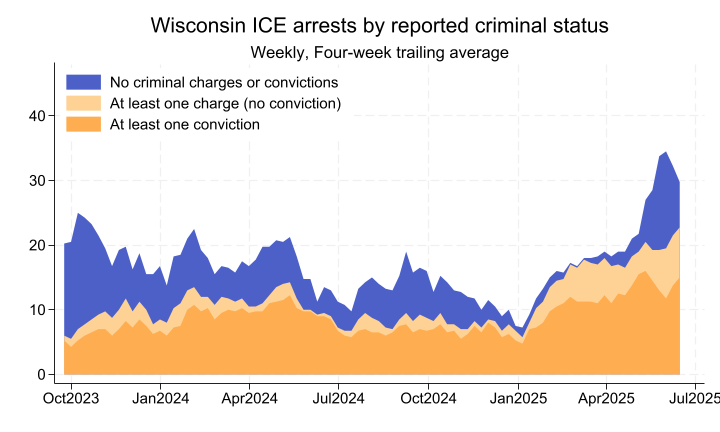

In [6]:
*| code-summary: Create Wisconsin chart
frame copy default WISCONSIN
frame WISCONSIN {
    quietly keep if ApprehensionState == "WISCONSIN"
    gen week_starting = date - dow(date)
    collapse (sum) n, by(cs_id week_starting)
    quietly {
        xtset cs_id week_starting
        tsfill, full
        assert missing(n) if dow(week_starting) != 0
        keep if dow(week_starting) == 0
        assert dow(week_starting) == 0
        replace n = 0 if missing(n)
        gen n_4w_ma = (F7.n + n + L7.n + L14.n)/4
        drop n
        drop if missing(n_4w_ma)
        reshape wide n_4w_ma, i(week_starting) j(cs_id)
    }
    gen cumul2_4w = n_4w_ma1 + n_4w_ma2
    gen cumul3_4w = cumul2_4w + n_4w_ma3

    label var n_4w_ma1 "At least one conviction"
    label var cumul2_4w "At least one charge (no conviction)"
    label var cumul3_4w "No criminal charges or convictions"
    format week_starting %tdMonCCYY
    twoway (area cumul3_4w cumul2_4w n_4w_ma1 week_starting if week_starting >= mdy(9,20,2023), ///
            color("#102BB6" "#FEC170" "#FE9116") fintensity(75 75 75) lwidth(none none none)), ///
        xtitle("") legend(ring(0) bplacement(11)) xlabel(#10) ///
        yscale(range(46.7))  ///
        title("Wisconsin ICE arrests by reported criminal status") ///
        subtitle("Weekly, Four-week trailing average")
}

Total Wisconsin arrests had apparently been comparable to pre-2025 rates until the past couple months. And the recent increase is not as dramatic as that experienced by California or the U.S. as a whole.

There is a lot more that could be done with this data. Ideally someone would put up some interactive charts so that answering a question like this would be easier. If I become aware of any, I'll put the link(s) here.